# Feature Importance

### NOTE: There is an error raised within this notebook when splitting training and test sets. 
ValueError: The least populated class in y has only 1 member, which is too few. 


SHAP values and XGBoost built-in feature importance are two popular techniques for determining feature importance.

SHAP values are computed by analyzing the impact of each feature on the model's output when that feature is included or excluded.

XGBoost is a gradient-boosting library that includes a built-in feature importance function that ranks features based on how often they are used to split the data in the boosting process. The XGBoost feature importance function takes into account the contribution of each feature to the model's accuracy.

Both SHAP values and XGBoost built-in feature importance provide valuable insights into the importance of different features in a dataset. These techniques may produce different rankings of feature importance so it is useful to compare their results to get a more comprehensive understanding of the importance of different features.

In [ ]:
%load_ext jupyter_black

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from utils import get_training_dataset

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Read csv file and import to df
df = pd.read_csv("data/updated_corr.csv")
df.head()

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,mean_slope,...,std_tri,mean_elev,coast_length,with_coast,urban,rural,water,total_pop,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,-0.213039,1.018526,...,2.699781,5.762712,3445.709753,1,0.0,0.00,1.00,0.000000,0.0,0.0
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,1.579400,...,4.585088,12.799127,8602.645832,1,0.0,0.00,1.00,0.000000,0.0,0.0
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.551764,...,1.527495,8.833333,5084.012925,1,0.0,0.01,0.99,197.339034,0.0,0.0
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,2.107949,...,11.677657,17.530431,55607.865950,1,0.0,0.31,0.69,4970.477311,0.0,0.0
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,3.538881,...,17.074011,31.931338,35529.342507,1,0.0,0.77,0.23,12408.594656,0.0,0.0


array([[<AxesSubplot:title={'center':'percent_houses_damaged'}>]],
      dtype=object)

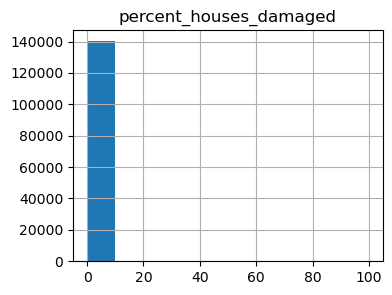

In [4]:
# Show histogram of damage
df.hist(column="percent_houses_damaged", figsize=(4, 3))

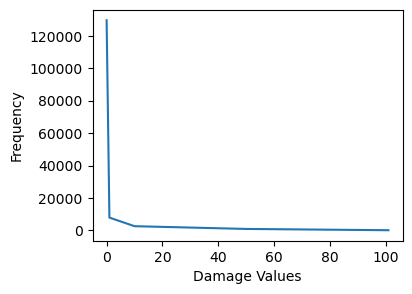

In [5]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [6]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    129600
(9e-05, 1.0]         7938
(1.0, 10.0]          2634
(10.0, 50.0]          939
(50.0, 101.0]         147
Name: percent_houses_damaged, dtype: int64

In [7]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])

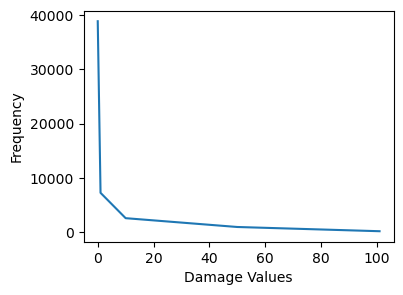

In [8]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [9]:
print(samples_per_bin2)
print(binsP2)

[38901  7232  2552   925   144]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [10]:
# Check the bins' intervalls
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    38901
(9e-05, 1.0]        7232
(1.0, 10.0]         2552
(10.0, 50.0]         925
(50.0, 101.0]        144
Name: percent_houses_damaged, dtype: int64

In [11]:
bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)

In [12]:
y_input_strat = bin_index2

In [13]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "mean_slope",
    "std_slope",
    "mean_tri",
    "std_tri",
    "mean_elev",
    "coast_length",
    "with_coast",
    "urban",
    "rural",
    "water",
    "total_pop",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_houses_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'mean_slope', 'std_slope', 'mean_tri',
       'std_tri', 'mean_elev', 'coast_length', 'with_coast', 'urban', 'rural',
       'water', 'total_pop', 'percent_houses_damaged_5years'],
      dtype='object')

In [14]:
# Split dataset into training set and test set

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["percent_houses_damaged"], stratify=y_input_strat, test_size=0.2
)

In [15]:
# XGBoost Reduced Overfitting
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

[14:35:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [16]:
X_train4shapely = pd.DataFrame(data=X_train, columns=features)

In [17]:
explainer_xgb = shap.Explainer(xgb_model, X_train4shapely)
shap_values_xgb = explainer_xgb(X_train4shapely)

 97%|=================== | 38536/39803 [00:30<00:00]       

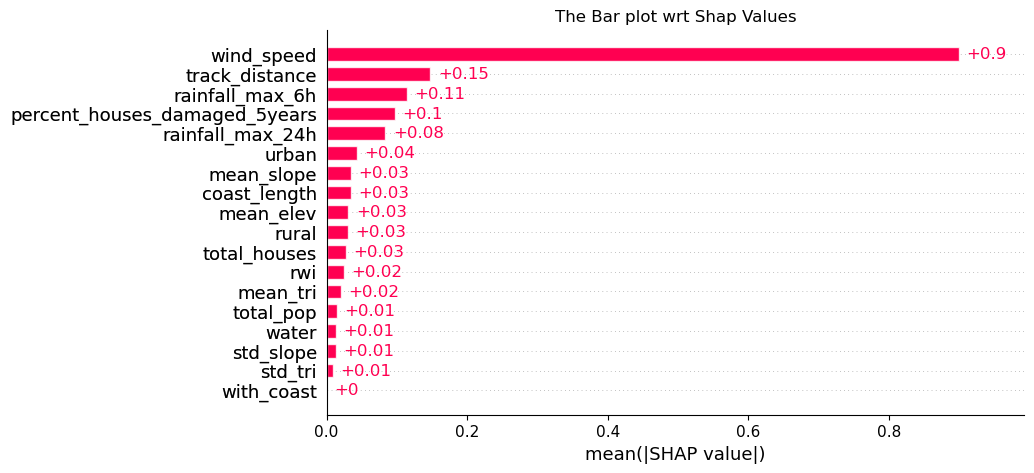

In [18]:
# Showing Barplot
plt.title("The Bar plot wrt Shap Values")
shap.plots.bar(shap_values_xgb, max_display=25, show=False)
plt.gcf().set_size_inches(9, 5)
plt.show()

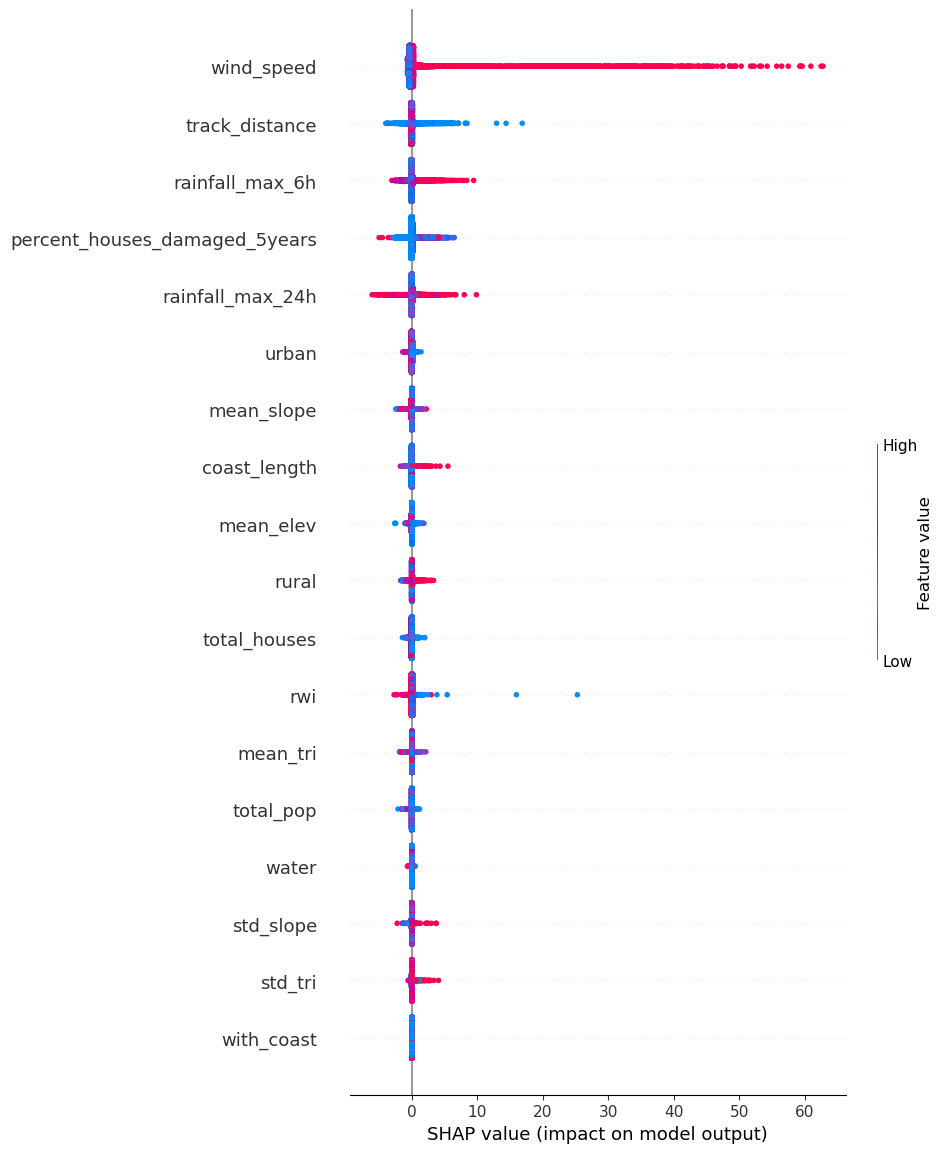

In [19]:
# Showing Beeswarm Plot
# plt.gcf().set_size_inches(4, 3)
shap.plots.beeswarm(
    shap_values_xgb,
    max_display=25,
    plot_size=0.7,
    # order=shap_values_xgb.abs.max(0)#, color="shap_red"
)

Text(0.5, 0, 'Feature Importance values')

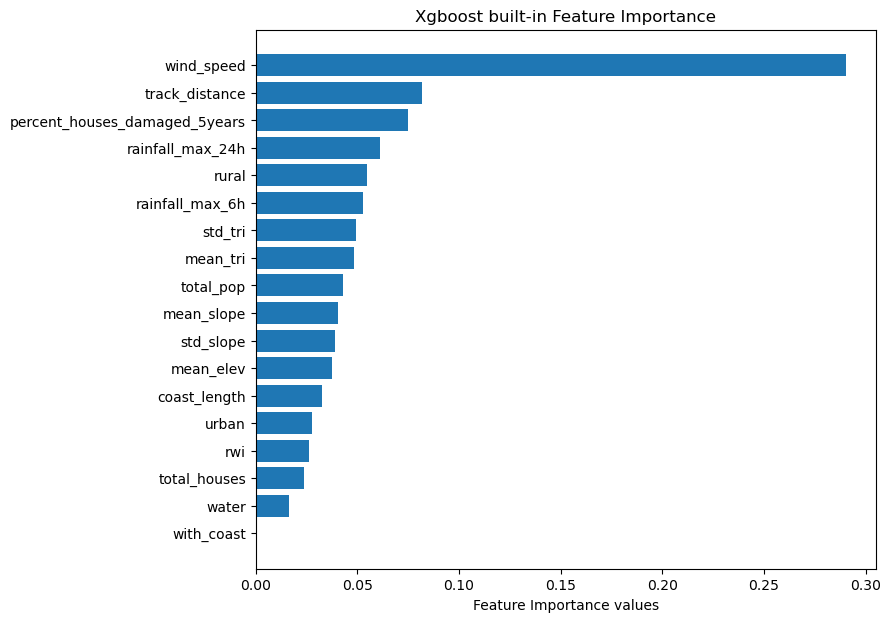

In [20]:
# Xgboost Built-in Feature Importance

plt.rcParams.update({"figure.figsize": (8.0, 7.0)})
plt.rcParams.update({"font.size": 10})

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.title("Xgboost built-in Feature Importance")
plt.xlabel("Feature Importance values")